In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import random
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations import Compose, Normalize, HorizontalFlip, Rotate, ColorJitter
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy.optimize import minimize

# ==============================================================================
# 0. Global Settings
# ==============================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)

# ==============================================================================
# 1. Preprocessing Functions
# ==============================================================================
def circle_crop(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_image = image[y:y + h, x:x + w]
    return cropped_image

def apply_ben_graham_preprocessing(image, sigmaX=30):
    blurred_image = cv2.GaussianBlur(image, (0, 0), sigmaX)
    processed_image = cv2.addWeighted(image, 4, blurred_image, -4, 128)
    return processed_image

def preprocess_directory(input_dir, output_dir, image_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Creating directory: {output_dir}")

    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"\nStarting to process directory: {input_dir}")
    for filename in tqdm(image_files, desc=f"Processing {os.path.basename(input_dir)}"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        image = cv2.imread(input_path)
        if image is None:
            continue

        processed_image = circle_crop(image)
        processed_image = cv2.resize(processed_image, (image_size, image_size))
        processed_image = apply_ben_graham_preprocessing(processed_image)
        cv2.imwrite(output_path, processed_image)

    print(f"Processing complete! Processed images saved to: {output_dir}")


# ==============================================================================
# 2. PyTorch Model and Data Classes
# ==============================================================================
def replace_batchnorm_with_groupnorm(module, num_groups=32):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            if num_channels % num_groups == 0:
                setattr(module, name, nn.GroupNorm(num_groups=num_groups, num_channels=num_channels))
        else:
            replace_batchnorm_with_groupnorm(child, num_groups)

class EfficientNetModel(nn.Module):
    def __init__(self, model_name, pretrained_model_path=None):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        replace_batchnorm_with_groupnorm(self.model)
        
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 1)
        )
        if pretrained_model_path and os.path.exists(pretrained_model_path):
            self.model.load_state_dict(torch.load(pretrained_model_path), strict=False)
        elif pretrained_model_path:
            print(f"Warning: Pretrained model path not found: {pretrained_model_path}")

    def forward(self, x):
        return self.model(x)

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
    def __len__(self):
        return len(self.labels_df)
    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx, 0]
        label = float(self.labels_df.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_id + '.png')
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transform:
                img = self.transform(image=img)["image"]
            return img, label
        except Exception as e:
            return self.__getitem__((idx + 1) % len(self))

def get_transforms(data_type='train'):
    if data_type == 'train':
        return Compose([
            Rotate(limit=40, p=0.5),
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.3),
            HorizontalFlip(p=0.5),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return Compose([
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

# ==============================================================================
# 3. Training and Prediction Functions
# ==============================================================================
def train(model, train_loader, valid_loader, device, num_epochs, lr, image_size):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_valid_kappa = 0.0
    epochs_no_improve = 0
    patience = 5
    save_path = os.path.join(os.getcwd(), f'best_model_kappa_{image_size}.pth')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        
        model.eval()
        all_valid_labels = []
        all_valid_preds = []
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Validating"):
                images = images.to(device)
                outputs = model(images).squeeze()
                all_valid_labels.extend(labels.cpu().numpy())
                preds_np = outputs.cpu().numpy()
                all_valid_preds.extend(np.atleast_1d(preds_np))
        
        rounded_preds = np.round(all_valid_preds).astype(int)
        valid_kappa = cohen_kappa_score(all_valid_labels, rounded_preds, weights='quadratic')

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"  Training Loss: {train_loss:.4f}")
        print(f"  Validation Kappa (rounded): {valid_kappa:.4f}")
        print(f"  Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step()

        if valid_kappa > best_valid_kappa:
            best_valid_kappa = valid_kappa
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"  -> Saved new best model! Validation Kappa: {best_valid_kappa:.4f}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break

class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0
    def _kappa_loss(self, coef, X, y):
        X_p = self.predict(X, coef)
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll
    def fit(self, X, y):
        loss_partial = lambda coef: self._kappa_loss(coef, X, y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = minimize(loss_partial, initial_coef, method='nelder-mead')['x']
        print(f"Optimized thresholds: {self.coef_}")
    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]: X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]: X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]: X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]: X_p[i] = 3
            else: X_p[i] = 4
        return X_p.astype(int)

def get_validation_predictions(loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting validation predictions"):
            images = images.to(device)
            outputs = model(images).squeeze()
            all_labels.extend(labels.cpu().numpy())
            preds_np = outputs.cpu().numpy()
            all_preds.extend(np.atleast_1d(preds_np))
    return np.array(all_preds), np.array(all_labels)

def load_and_predict_test_data(test_csv_path, img_dir, model, device, coefficients):
    test_df = pd.read_csv(test_csv_path)
    predictions = []
    test_transform = get_transforms('test')
    rounder = OptimizedRounder()
    model.eval()
    for img_id in tqdm(test_df['id_code'], desc="Predicting on test set"):
        img_path = os.path.join(img_dir, img_id + '.png')
        if not os.path.exists(img_path):
            predictions.append(-1) 
            continue
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_tensor = test_transform(image=img)["image"].unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(image_tensor).squeeze().cpu().numpy()
        predictions.append(pred)
    if -1 in predictions:
        valid_preds = [p for p in predictions if p != -1]
        rounded_valid_preds = np.round(valid_preds).astype(int)
        if len(rounded_valid_preds) > 0: mode_val = pd.Series(rounded_valid_preds).mode()[0]
        else: mode_val = 0
        predictions = [mode_val if p == -1 else p for p in predictions]
    test_preds_rounded = rounder.predict(np.array(predictions), coefficients)
    test_df['diagnosis'] = test_preds_rounded
    submission_file = os.path.join(os.getcwd(), 'submission.csv')
    test_df.to_csv(submission_file, index=False)
    print(f"\nPredictions saved to {submission_file}")

# ==============================================================================
# 4. Main Execution Logic
# ==============================================================================
if __name__ == "__main__":
    # --- Step 1: Define Paths and Parameters ---
    print("--- Step 1: Initializing paths and parameters ---")
    MODEL_NAME = 'efficientnet_b6'
    IMAGE_SIZE = 512
    BATCH_SIZE = 4
    NUM_EPOCHS = 30
    LEARNING_RATE = 1e-4
    NUM_WORKERS = 2
    
    # --- Path Definitions ---
    COMPETITION_DATA_DIR = '/kaggle/input/aptos2019-blindness-detection'
    source_train_dir = os.path.join(COMPETITION_DATA_DIR, 'train_images')
    source_test_dir = os.path.join(COMPETITION_DATA_DIR, 'test_images')
    train_label_file = os.path.join(COMPETITION_DATA_DIR, 'train.csv')
    test_label_file = os.path.join(COMPETITION_DATA_DIR, 'test.csv')
    
    PREPROCESSED_DATA_INPUT_DIR = '/kaggle/input/images-preprocessed-512'
    
    PREPROCESSED_DATA_WORKING_DIR = '/kaggle/working'

    PRETRAINED_MODEL_PATH = '/kaggle/input/efficientnetb6/pytorch/default/1/pytorch_model_effb6.bin'
    
    model_path = os.path.join(os.getcwd(), f'best_model_kappa_{IMAGE_SIZE}.pth')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device being used: {device}")

    # --- Step 2: Smartly Decide Which Image Dataset to Use ---
    print("\n--- Step 2: Checking preprocessed data ---")
    
    final_train_image_dir = os.path.join(PREPROCESSED_DATA_INPUT_DIR, f'train_images_preprocessed_{IMAGE_SIZE}')
    final_test_image_dir = os.path.join(PREPROCESSED_DATA_INPUT_DIR, f'test_images_preprocessed_{IMAGE_SIZE}')

    if os.path.exists(final_train_image_dir) and os.path.exists(final_test_image_dir):
        print(f"Successfully found uploaded preprocessed data, using path: {PREPROCESSED_DATA_INPUT_DIR}")
    else:
        print(f"Preprocessed data not found at '{PREPROCESSED_DATA_INPUT_DIR}'.")
        print("Will perform real-time preprocessing and save images to /kaggle/working/ directory.")
        final_train_image_dir = os.path.join(PREPROCESSED_DATA_WORKING_DIR, f'train_images_preprocessed_{IMAGE_SIZE}')
        final_test_image_dir = os.path.join(PREPROCESSED_DATA_WORKING_DIR, f'test_images_preprocessed_{IMAGE_SIZE}')
        
        preprocess_directory(source_train_dir, final_train_image_dir, IMAGE_SIZE)
        preprocess_directory(source_test_dir, final_test_image_dir, IMAGE_SIZE)

    # --- Step 3: Run Model Training (if needed) ---
    print("\n--- Step 3: Checking for existing model ---")
    run_training = True
    if os.path.exists(model_path):
        print(f"Model file found at {model_path}. Skipping training.")
        run_training = False

    if run_training:
        print("Starting model training...")
        all_labels_df = pd.read_csv(train_label_file)
        train_df, valid_df = train_test_split(
            all_labels_df, test_size=0.2, random_state=42, stratify=all_labels_df['diagnosis']
        )
        train_dataset = CustomImageDataset(final_train_image_dir, train_df, transform=get_transforms('train'))
        valid_dataset = CustomImageDataset(final_train_image_dir, valid_df, transform=get_transforms('valid'))
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
        
        model = EfficientNetModel(MODEL_NAME, pretrained_model_path=PRETRAINED_MODEL_PATH).to(device)
        train(model, train_loader, valid_loader, device, NUM_EPOCHS, LEARNING_RATE, IMAGE_SIZE)
    
    # --- Step 4: Optimize Rounding Thresholds ---
    print("\n--- Step 4: Optimizing rounding thresholds ---")
    if not os.path.exists(model_path):
         print("Error: Model file not found. Cannot perform threshold optimization.")
    else:
        all_labels_df = pd.read_csv(train_label_file)
        _, valid_df_for_opt = train_test_split(
            all_labels_df, test_size=0.2, random_state=42, stratify=all_labels_df['diagnosis']
        )
        valid_dataset_for_opt = CustomImageDataset(final_train_image_dir, valid_df_for_opt, transform=get_transforms('valid'))
        valid_loader_for_opt = DataLoader(valid_dataset_for_opt, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        
        model_for_opt = EfficientNetModel(MODEL_NAME, pretrained_model_path=None).to(device)
        model_for_opt.load_state_dict(torch.load(model_path, map_location=device))
        
        val_preds, val_labels = get_validation_predictions(valid_loader_for_opt, model_for_opt, device)
        opt_rounder = OptimizedRounder()
        opt_rounder.fit(val_preds, val_labels)
        optimized_coefficients = opt_rounder.coef_
        
        optimized_preds = opt_rounder.predict(val_preds, optimized_coefficients)
        final_val_kappa = cohen_kappa_score(val_labels, optimized_preds, weights='quadratic')
        print(f"Final optimized validation Kappa: {final_val_kappa:.4f}")
    
        # --- Step 5: Load Best Model and Predict ---
        print("\n--- Step 5: Loading best model and predicting on test set ---")
        model_for_pred = EfficientNetModel(MODEL_NAME, pretrained_model_path=None).to(device)
        model_for_pred.load_state_dict(torch.load(model_path, map_location=device))
        load_and_predict_test_data(test_label_file, final_test_image_dir, model_for_pred, device, optimized_coefficients)

    print("\n--- Script execution complete ---")

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


--- Step 1: Initializing paths and parameters ---
Device being used: cuda

--- Step 2: Checking preprocessed data ---
Successfully found uploaded preprocessed data, using path: /kaggle/input/images-preprocessed-512

--- Step 3: Checking for existing model ---
Starting model training...


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.89it/s]



Epoch 1/30
  Training Loss: 0.7944
  Validation Kappa (rounded): 0.8271
  Current Learning Rate: 0.000100
  -> Saved new best model! Validation Kappa: 0.8271


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.96it/s]



Epoch 2/30
  Training Loss: 0.4460
  Validation Kappa (rounded): 0.8858
  Current Learning Rate: 0.000100
  -> Saved new best model! Validation Kappa: 0.8858


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.95it/s]



Epoch 3/30
  Training Loss: 0.3362
  Validation Kappa (rounded): 0.8592
  Current Learning Rate: 0.000099


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.94it/s]



Epoch 4/30
  Training Loss: 0.3237
  Validation Kappa (rounded): 0.8788
  Current Learning Rate: 0.000098


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.94it/s]



Epoch 5/30
  Training Loss: 0.3031
  Validation Kappa (rounded): 0.8985
  Current Learning Rate: 0.000096
  -> Saved new best model! Validation Kappa: 0.8985


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.96it/s]



Epoch 6/30
  Training Loss: 0.2528
  Validation Kappa (rounded): 0.9101
  Current Learning Rate: 0.000093
  -> Saved new best model! Validation Kappa: 0.9101


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.96it/s]



Epoch 7/30
  Training Loss: 0.2335
  Validation Kappa (rounded): 0.8947
  Current Learning Rate: 0.000091


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.95it/s]



Epoch 8/30
  Training Loss: 0.2432
  Validation Kappa (rounded): 0.8908
  Current Learning Rate: 0.000087


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.96it/s]



Epoch 9/30
  Training Loss: 0.2000
  Validation Kappa (rounded): 0.8575
  Current Learning Rate: 0.000084


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.93it/s]



Epoch 10/30
  Training Loss: 0.1714
  Validation Kappa (rounded): 0.8916
  Current Learning Rate: 0.000080


Validating: 100%|██████████| 184/184 [00:14<00:00, 12.95it/s]



Epoch 11/30
  Training Loss: 0.1761
  Validation Kappa (rounded): 0.8508
  Current Learning Rate: 0.000075

Early stopping triggered after 5 epochs with no improvement.

--- Step 4: Optimizing rounding thresholds ---


Getting validation predictions: 100%|██████████| 184/184 [00:15<00:00, 12.05it/s]


Optimized thresholds: [0.54836009 1.51264196 2.50057982 3.16563758]
Final optimized validation Kappa: 0.9140

--- Step 5: Loading best model and predicting on test set ---


Predicting on test set: 100%|██████████| 1928/1928 [01:24<00:00, 22.78it/s]


Predictions saved to /kaggle/working/submission.csv

--- Script execution complete ---


In [4]:
# Install if needed
!pip install pytorch-grad-cam

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


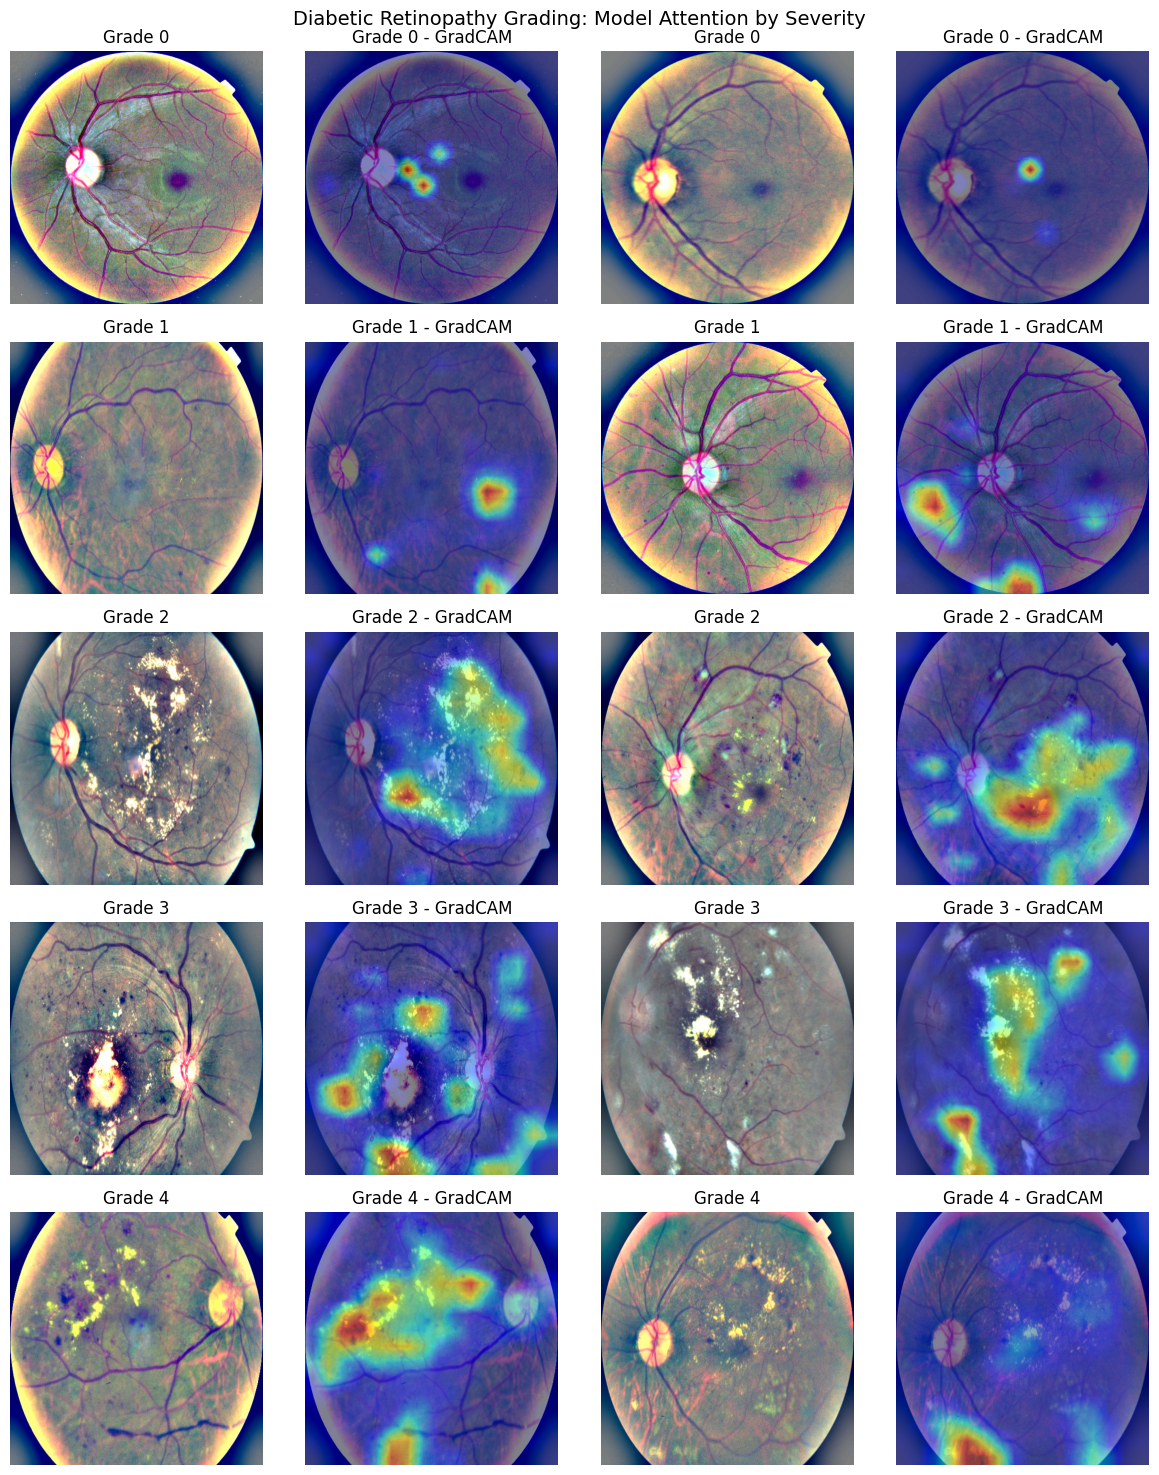

In [5]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SimpleGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate(self, input_tensor):
        self.model.eval()
        output = self.model(input_tensor)
        
        self.model.zero_grad()
        output.backward()
        
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(512, 512), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.squeeze().cpu().numpy()

# Load model
model = EfficientNetModel(MODEL_NAME, pretrained_model_path=None).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

# Initialize GradCAM
target_layer = model.model.conv_head
cam = SimpleGradCAM(model, target_layer)

# Prepare data
all_labels_df = pd.read_csv(train_label_file)
_, valid_df = train_test_split(all_labels_df, test_size=0.2, random_state=42, stratify=all_labels_df['diagnosis'])
valid_df = valid_df.reset_index(drop=True)
valid_dataset = CustomImageDataset(final_train_image_dir, valid_df, transform=get_transforms('valid'))

# Generate visualizations
fig, axes = plt.subplots(5, 4, figsize=(12, 15))

for grade in range(5):
    grade_mask = valid_df['diagnosis'] == grade
    grade_indices = valid_df[grade_mask].index.tolist()[:2]
    
    for i, idx in enumerate(grade_indices):
        img_tensor, label = valid_dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device).requires_grad_(True)
        
        grayscale_cam = cam.generate(input_tensor)
        
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        heatmap = plt.cm.jet(grayscale_cam)[:, :, :3]
        overlay = 0.5 * img_np + 0.5 * heatmap
        overlay = np.clip(overlay, 0, 1)
        
        axes[grade, i*2].imshow(img_np)
        axes[grade, i*2].set_title(f'Grade {grade}')
        axes[grade, i*2].axis('off')
        
        axes[grade, i*2 + 1].imshow(overlay)
        axes[grade, i*2 + 1].set_title(f'Grade {grade} - GradCAM')
        axes[grade, i*2 + 1].axis('off')

plt.suptitle('Diabetic Retinopathy Grading: Model Attention by Severity', fontsize=14)
plt.tight_layout()
plt.savefig('gradcam_by_grade.png', dpi=150, bbox_inches='tight')
plt.show()